# Soil food web interactive analysis and visualization 

This notebook implements our approach to interactive analysis and visualization of soil food webs using Jupyter notebooks and interactive IPython widgets. Therefore, it does not require programming skills beyond setting parameter values and running parts of the notebook. ... BLABLA

## Part 1: preparing the environment and loading the data

In the very first part of the notebook all the required modules and libraries are imported and few helper functions are defined. Next, a data file containing the soil food network in the form of a `NxN` 0/1 matrix is loaded using the widget which allows uploading a file to the memory. Currently, `.csv` files are supported. The matrix is also displayed inline to ensure that the data was loaded correctly.

In [298]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [476]:
import importlib
import io
import codecs
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import math
from operator import itemgetter
from pyvis.network import Network as net

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual,  HBox, VBox
from IPython.display import display, HTML

from utils.ui_functions import alert, StopExecution, make_download_button
from utils.conf import my_style, my_layout

alert_user = lambda message: display(HTML(alert(message)))

### 1.1 Loading the network matrix

In [300]:
# ***Development code***
# Create a pandas df from csv
sfw_matrix = pd.read_csv("data/matrice Marko-4_Martin.csv", header=0, index_col=0, sep=";")
#pd.set_option("max_columns", None)
#sfw_matrix

In [301]:
# widgets.FileUpload(accept='.csv',multiple=False)
# matrix_uploader = widgets.FileUpload()
# display(matrix_uploader)

In [302]:
# try:
#     matrix_file_name, matrix_file_data = list(matrix_uploader.value.items())[0]
# except Exception:
#     alert_user('Please load the food web matrix data file the cell above!\nThe program cannot continue without this data.')
#     raise StopExecution    
# sfw_matrix = pd.read_csv(io.StringIO(codecs.decode(matrix_file_data['content'], encoding="utf-8")),
#                          header=0, 
#                          index_col=0, 
#                          sep=";")

# if sfw_matrix.shape[0]!=sfw_matrix.shape[1]:
#     alert_user('Invalid graph matrix: it must have NxN shape.')
#     raise StopExecution

# @interact(nrows=widgets.IntSlider(description='Rows:', min=3, max=sfw_matrix.shape[1], step=1, value=5),
#           ncols=widgets.IntSlider(description='Columns:', min=3, max=sfw_matrix.shape[0], step=1, value=10))
# def show_soil_food_web_matrix(nrows, ncols):
#     pd.set_option("display.max_rows", nrows)
#     pd.set_option("display.max_columns", ncols)
#     display(sfw_matrix)

### 1.2 Loading the trophic level matrix

If we have the trophic level data it is possible to load it here. It must have the `Nx1` shape. If no such data is available, the following two cells are skipped and the trophic level will not be used (all nodes will have the same value).

In [303]:
# ***Development code***
# Import trophic levels
trophic_levels = pd.read_csv("data/trophic_levels_1_0.csv", index_col=0, header=None, delimiter=";", names=["trophic_level"])
trophic_levels = trophic_levels.squeeze()

# Create dict from trophic level Series
troph_lev_dict = trophic_levels.to_dict()
#troph_lev_dict

In [304]:
# widgets.FileUpload(accept='csv',multiple=False)
# trophic_level_uploader = widgets.FileUpload()
# display(trophic_level_uploader)

In [305]:
# try:
#     trophic_level_file_name, trophic_level_file_data = list(trophic_level_uploader.value.items())[0]
# except Exception:
#     alert_user('Please load the file with trophic level data in the cell above!\nThe program cannot continue without trophic level data.')
#     raise StopExecution
# trophic_levels = pd.read_csv(io.StringIO(codecs.decode(trophic_level_file_data['content'], encoding='utf-8')),
#                              index_col=0, header=None, delimiter=";", names=['trophic_level'])

# if trophic_levels.shape[1]!=1:
#     alert_user('Invalid thropic matrix: it must have Nx1 shape.')
#     raise StopExecution
# if trophic_levels.shape[0] != sfw_matrix.shape[0]:
#     alert_user('Invalid number of rows in the trophic matrix: trophic level must be defined for all organisms (nodes).')
#     raise StopExecution
    
# pd.set_option('display.max_rows', None)
# display(trophic_levels.sort_values('trophic_level'))
# trophic_levels = trophic_levels.squeeze()
# trophic_levels_dict = trophic_levels.to_dict()

## Part 2: Network construction and manipulation

### 2.1 Network construction

Using the provided adjacency matrix data and the trophic level data we will create the network structure and offer basic editing functions. 

In [306]:
G = nx.from_pandas_adjacency(sfw_matrix, create_using=nx.DiGraph)
# remove default edge weights
for n1, n2, d in G.edges(data=True):
    d.clear()
    
graph_name_input = widgets.Text(placeholder='The name of this network', value='My network', description='Name:', disabled=False, style=my_style)
rename_button = widgets.Button(description='Rename', disabled=False, button_style='primary',icon='edit')
rename_log = widgets.Output(layout={'border': '1px solid blue'})
display(rename_log)
def rename_graph(widget_name):
    G.name = graph_name_input.value
    rename_log.clear_output()
    rename_log.append_display_data(f'Graph renamed to "{G.name}"')
rename_button.on_click(rename_graph)

# TODO make sure the network has a name
HBox([graph_name_input, rename_button])

Output(layout=Layout(border='1px solid blue'))

In [308]:
if not G.name:
    alert_user('The network does not have a name!\nPlease use the "Rename" button in the above cell.')
    raise StopExecution

print('--- Basic network info ---')
print(f'Name: {G.name}')
typ = 'directed' if nx.is_directed(G) else 'undirected'
print(f'Type: {typ}')
print(f'Nodes: {G.number_of_nodes()}')
print(f'Edges: {G.number_of_edges()}')
sc = 'yes' if nx.is_strongly_connected(G) else 'no'
print(f'Strongly connected: {sc}')
print(f'Density: {nx.density(G):.5f}')

--- Basic network info ---
Name: My network
Type: directed
Nodes: 24
Edges: 94
Strongly connected: no
Density: 0.17029


### 2.2 Network manipulation

In [309]:
select_node_dropdown = widgets.Dropdown(options=sorted(list(G.nodes)), description='Selected node:', disabled=False, 
                                        layout=my_layout, style=my_style)
delete_button = widgets.Button(description='Delete this node', disabled=False, button_style='danger',icon='trash')
delete_log = widgets.Output(layout={'border': '1px solid blue'})
def button_action(widget_name):
    selected_node = select_node_dropdown.value
    if selected_node:
        G.remove_node(selected_node)
        select_node_dropdown.options = sorted(list(G.nodes))
        delete_log.append_display_data(f'Node "{selected_node}" was removed')
delete_button.on_click(button_action)
display(delete_log)
HBox([select_node_dropdown, delete_button])

Output(layout=Layout(border='1px solid blue'))

In [529]:
# To-Do: add adding nodes and adding/removing edges

## Part 3: Network visualization

In [310]:
import textwrap
import webbrowser
from pyvis.network import Network
from utils import conf
from utils import functions
from utils.ui_functions import make_download_button
import copy

out = widgets.Output(layout={'border': '0px'})
@out.capture()
def draw_network_inline(widget_name):
    out.clear_output()
    vis_G = prepare_visualization()
    GG = copy.copy(vis_G)
    GG.conf = False
    GG.set_options(conf.hierarchical_food_web_visual_settings_inline)
    display(HTML(GG.generate_html()))
    # display(GG.show(f'{G.name}.html'))

def draw_network_new_tab(widget_name):
    vis_G = prepare_visualization()
    GG = copy.copy(vis_G)
    GG.conf = True
    GG.set_options(conf.hierarchical_food_web_visual_settings_standalone)
    web_page = f'{G.name}.html'
    GG.write_html(web_page)
    webbrowser.open(web_page)

color_select = widgets.Dropdown(options=['viridis', 'plasma', 'inferno', 'magma', 'cividis', 'bone', 'pink',
                                         'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia', 'hot', 'afmhot', 
                                         'gist_heat', 'copper'],
                                value='spring',           
                                description='Colormap:',
                                disabled=False)
shape_select = widgets.Dropdown(options=['ellipse', 'circle', 'database', 'box', 'text', 'diamond', 'dot', 'star', 
                                         'triangle', 'triangleDown', 'hexagon', 'square'],
                                value='box',           
                                description='Node shape:',
                                disabled=False)
label_width_slider  = widgets.IntSlider(value=20, min=6, max=40, step=2, description='Label width:', disabled=False,
                                        continuous_update=False, orientation='horizontal', readout=True, readout_format='d')
draw_inline_button = widgets.Button(description='Draw inline', disabled=False, button_style='primary')
draw_outside_button = widgets.Button(description='Open in new tab', disabled=False, button_style='primary')
draw_outside_button.style.button_color = 'green'
draw_inline_button.on_click(draw_network_inline)
draw_outside_button.on_click(draw_network_new_tab)

def prepare_visualization():
    colors = functions.get_colors(len(set(trophic_levels)), colormap=color_select.value)
    vis_G = Network('800px', '1200px', notebook=False)
    # add nodes
    for node in G.nodes():
        vis_G.add_node(node, 
                       label='\n'.join(textwrap.wrap(node, label_width_slider.value, break_long_words=True)), 
                       level=max(trophic_levels) - trophic_levels_dict[node], 
                       shape=shape_select.value,
                       color=colors[trophic_levels_dict[node]])
    # and edges
    for source, target in list(G.edges()):
        vis_G.add_edge(source, target)
    return vis_G  


display(VBox([color_select, shape_select, label_width_slider, draw_inline_button, draw_outside_button]))
display(make_download_button(G.name))
display(out)

HTML(value='<html>\n<head>\n<meta name="viewport" content="width=device-width, initial-scale=1">\n</head>\n<bo…

Output(layout=Layout(border='0px'))

## Part 4: Network analysis

### 4.1 Centrality meassures
Degree centrality (fraction of nodes it is connected to ).
Out-degree centrality (fraction of nodes its outgoing edges are connected to).
In-degree centrality (fraction of nodes its incoming edges are connected to).
Betweenes Centrality (sum of the fraction of all-pairs shortest paths that pass through).
Closseness Centrality meassure (reciprocal of the average shortest path distance to u over all n-1 reachable nodes)

In [531]:
# Združi spodaj!
# degree centrality
degree = nx.degree_centrality(G)
# sorted(degree.items(), key=lambda item: item[1], reverse=True)

# out-degree
out_degree = nx.out_degree_centrality(G)
# sorted(degree.items(), key=lambda item: item[1], reverse=True)

# in-degree
in_degree = nx.in_degree_centrality(G)
# sorted(in_degree.items(), key=lambda item: item[1], reverse=True)

# betweenness_centrality
betw_cent = nx.betweenness_centrality(G)
# sorted(betw_cent.items(), key=lambda item: item[1], reverse=True)

# closeness_centrality
clos_cent = nx.closeness_centrality(G)
# sorted(clos_cent.items(), key=lambda item: item[1], reverse=True)

# summary table of measures
df_measures = pd.DataFrame.from_dict({"degree": degree, "out-degree": out_degree, "in-degree": in_degree, 
                                     "betweenness centrality": betw_cent, "closeness centrality": clos_cent})
#df_measures

In [333]:
# TO-DO: make download csv button for centrality measures

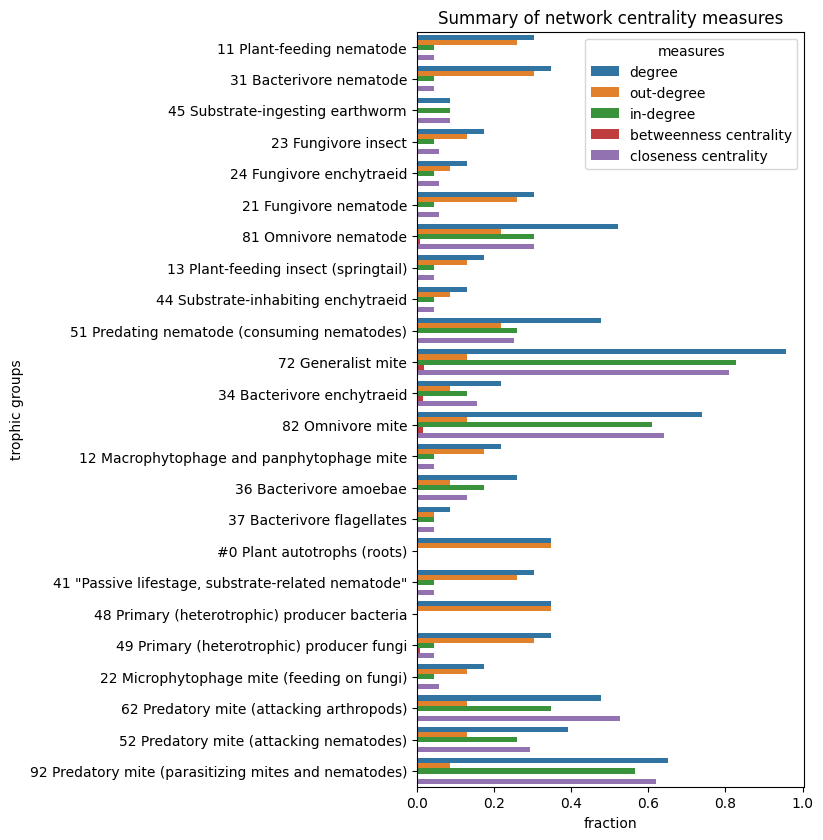

In [332]:
# Convert df_measures to long format
df_meassures_melt = df_measures.reset_index()
df_meassures_melt.rename(columns = {"index" : "trophic groups"}, inplace=True)
df_meassures_melt = df_meassures_melt.melt("trophic groups", var_name='measures', value_name='fraction')
#df_meassures_melt

# barplot of summary table
fig, plot = plt.subplots(figsize=(5, 10), dpi=100)
sns.barplot(x="fraction", y="trophic groups", hue='measures', data=df_meassures_melt)
plot.set_title("Summary of network centrality measures")
plot.figure.savefig("outputs/barplot_cent_measures.png")

In [532]:
# To-Do: ask Christian if ratio of in/out-degre would be useful?

### 4.2 Network complexity and connectance

Complexity as the average number of links per species (*Christian needs to confirm and which one to use?)

In [533]:
# Ask Christian if we keep his complexity? Its similar to density above.

In [344]:
# Christian complexity
Chr_complex = G.number_of_edges() * G.number_of_nodes()

# Complexity (average number of links per species (Wikipedia())
from statistics import mean
def complexity(g):
    """Calculates the average number of edges (degree) per node in a graph g"""
    deg = g.degree()
    deg_ls = []
    for n, d in deg:
        deg_ls.append(d)
    
    return mean(deg_ls) 

# Connectance
connectance = G.number_of_edges() / (G.number_of_nodes())**2

print(f"Complexity: {complexity(G)}")
print(f"Connectance: {connectance}") 

Complexity: 7.833333333333333
Connectance: 0.16319444444444445


## Part 5: Modeling with experimental data

### 5.1 Load experimental data

In [316]:
# To-do: button to import experimental data

In [341]:
# ***Developer code***
df_field = pd.read_csv("data/RecastingFieldExperiment.txt", sep="\t")
#df_field

### 5.2 Preprocessing experiemtnal data

To-Do: Explain that these sections are specific to the case data

In [536]:
# Create df for Plot A # What if user has no plots?
df_field_a = df_field[df_field["Plot_ID"] == "A"].copy()
# Sort by OTU
df_field_a.sort_values("OTU", inplace=True)

# Add new column with removed log  
df_field_a["Biomass"] = 10**(df_field_a["Log10(Biomass)"])
df_field_a["Mass"] = 10**(df_field_a["Log10(Mass)"])
df_field_a["Abundance"] = 10**(df_field_a["Log10(Abundance)"])

# Quantify organisms
OTUs = df_field_a.OTU.unique()
print(f"Number of OTUs in plot A: {len(OTUs)}") #How should we name OTUs (organisms)? Or rather 
trophic_groups = df_field_a.Trophic_ID.unique()
print(f"Number of trophic groups in plot A: {len(trophic_groups)}")

# Create dictionary for number of times an organism appears (nr. of replicates)
organism_count = df_field_a.OTU.value_counts()
trophic_group_count = df_field_a.Trophic_ID.value_counts()

#df_field_a

Number of OTUs in plot A: 96
Number of trophic groups in plot A: 23


In [537]:
# To-do: piechart

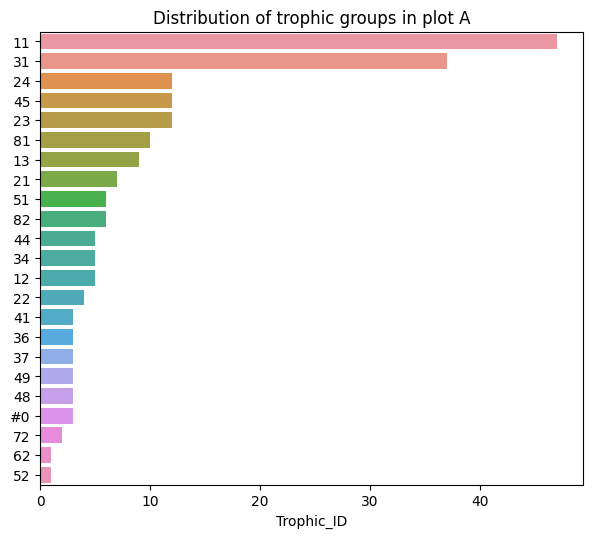

In [407]:
# Should we plot distribution of trophic groups?
fig, plot = plt.subplots(figsize = (7,6), dpi = 100)
plot = sns.barplot(y=list(trophic_group_count.index), x=trophic_group_count)
plot.set_title('Distribution of trophic groups in plot A', fontsize = 12);

### 5.3 Calculate the aggregated biomas, mass and abundance per trophic group [can be part of 5.2?]

In [538]:
# To-do: needs to be done in one cell

In [443]:
# Calculate the aggregated biomas per Trophic_ID
# Create dictionary mapping OTUs to Trophic_IDs
OTU2trophicID = pd.Series(df_field_a.Trophic_ID.values, df_field_a.OTU.values).to_dict()

# Calcualte avg biomas by OTU groups
df_group_A_bm = df_field_a.groupby(["OTU"], as_index=False).Biomass.mean()
df_group_A_bm.Biomass = df_group_A_bm.Biomass.round(2)

# Add Trophic_ID to df_group_a
for idx, otu in df_group_A_bm["OTU"].iteritems():
    df_group_A_bm.loc[idx, "Trophic_ID"] = OTU2trophicID[otu]

# Calcualte sum of biomas by trophic groups
df_group_A_bm = df_group_A_bm.groupby("Trophic_ID", as_index=False).Biomass.sum()

# Create dictionary for avg biomass feature
avg_biomass_A = pd.Series(df_group_A_bm.Biomass.values, df_group_A_bm.Trophic_ID.values).to_dict()

# Unify node names and Trophic_ID names in Biomass dict
for key_attr in list(avg_biomass_A):
    for key_node in list(G.nodes):
        if key_attr in key_node:
            avg_biomass_A[key_node] = avg_biomass_A.pop(key_attr)

# Round values
avg_biomass_A = {key : round(avg_biomass_A[key], 2) for key in avg_biomass_A}

# If no "92 Predatory mite (parasitizing mites and nematodes)" add them manually #Need to generalise?
avg_biomass_A["92 Predatory mite (parasitizing mites and nematodes)"] = 0
# dict(sorted(avg_biomass_A.items(), key=lambda item: item[1]))

In [431]:
# Should there be a comment: "'92 Predatory mite (parasitizing mites and nematodes)' was not detected in Plot A and C and has no biomass feature."

In [450]:
# Calculate the aggregated mass per Trophic_ID

# Calcualte avg mass by OTU group
df_group_A_m = df_field_a.groupby(["OTU"], as_index=False).Mass.mean()
# df_group_A_m.Mass = df_group_A_m.Mass.round(4)

# Add Trophic_ID to df_group_a
for idx, otu in df_group_A_m["OTU"].iteritems():
    df_group_A_m.loc[idx, "Trophic_ID"] = OTU2trophicID[otu]

df_group_A_m = df_group_A_m.groupby("Trophic_ID", as_index=False).Mass.sum()
df_group_A_m

# pd.set_option("max_rows", None)

# Create dictionary for avg mass feature
avg_mass_A = pd.Series(df_group_A_m.Mass.values, df_group_A_m.Trophic_ID.values).to_dict()

#Change key "#0" to 00
#avg_mass_A["00"] = avg_mass_A.pop("#0")

# Unify node names and Trophic_ID names in Mass dict
for key_attr in list(avg_mass_A):
    for key_node in list(G.nodes):
        if key_attr in key_node:
            avg_mass_A[key_node] = avg_mass_A.pop(key_attr)

# Round values, many values become 0?
# avg_mass_A = {key : round(avg_mass_A[key], 2) for key in avg_mass_A}
            
# If no "92 Predatory mite (parasitizing mites and nematodes)" add them manually
avg_mass_A["92 Predatory mite (parasitizing mites and nematodes)"] = 0
# dict(sorted(avg_mass_A.items(), key=lambda item: item[1]))

In [452]:
# Calculate the aggregated abundance per Trophic_ID

# Calcualte avg abundance by OTU group
df_group_A_ab = df_field_a.groupby(["OTU"], as_index=False).Abundance.mean()
# df_group_A_m.Abundance = df_group_A_m.Abundance.round(4)

# Add Trophic_ID to df_group_a
for idx, otu in df_group_A_ab["OTU"].iteritems():
    df_group_A_ab.loc[idx, "Trophic_ID"] = OTU2trophicID[otu]

df_group_A_ab = df_group_A_ab.groupby("Trophic_ID", as_index=False).Abundance.sum()
df_group_A_ab

# pd.set_option("max_rows", None)

# Create dictionary for avg mass feature
avg_abund_A = pd.Series(df_group_A_ab.Abundance.values, df_group_A_ab.Trophic_ID.values).to_dict()

#Change key "#0" to 00
#avg_mass_A["00"] = avg_mass_A.pop("#0")

# Unify node names and Trophic_ID names in Abundance dict
for key_attr in list(avg_abund_A):
    for key_node in list(G.nodes):
        if key_attr in key_node:
            avg_abund_A[key_node] = avg_abund_A.pop(key_attr)

# Round values
avg_abund_A = {key : round(avg_abund_A[key], 2) for key in avg_abund_A}            

# If no "92 Predatory mite (parasitizing mites and nematodes)" add them manually [CHECK for other plots!]
avg_abund_A["92 Predatory mite (parasitizing mites and nematodes)"] = 0
# dict(sorted(avg_abund_A.items(), key=lambda item: item[1]))

### 5.4 Adding trophic level, biomass, mass and abundance as attributes to the network

In [455]:
# Add trophic level as attribute
nx.set_node_attributes(G, troph_lev_dict, "trophic_level")
# Add biomas as attribute
nx.set_node_attributes(G, avg_biomass_A, "Biomass")
# Add mass as attribute
nx.set_node_attributes(G, avg_mass_A, "Mass")
# Add abundance as attribute
nx.set_node_attributes(G, avg_abund_A, "Abundance")
# G.nodes(data=True)

In [525]:
# To-Do: create a button to download final network with experimental data

In [526]:
# To-Do: visualisation of final network? Nodes reflecting size of attributes

In [ ]:
# ***Dev code***
## Create a pickle of the graph
#nx.write_gpickle(G, "objects/graph-A_4_0", protocol=5)

### 5.5 Calculating total biomas (and abundance?) per trophic level 

In [539]:
# to-do: visualise with log and linear

In [471]:
# Calculate biomass per trophic level
biomass_tl0, biomass_tl1, biomass_tl2, biomass_tl3 = 0.0, 0.0, 0.0, 0.0

for n in G.nodes():
    if G.nodes[n]["trophic_level"] == 0:
        biomass_tl0 += G.nodes[n]["Biomass"]
    elif G.nodes[n]["trophic_level"] == 1:
        biomass_tl1 += G.nodes[n]["Biomass"]
    elif G.nodes[n]["trophic_level"] == 2:
        biomass_tl2 += G.nodes[n]["Biomass"]
    elif G.nodes[n]["trophic_level"] == 3:
        biomass_tl3 += G.nodes[n]["Biomass"]
  
print("--- Total biomas per trophic level ---")           
print(f"Trophic level0 biomass: {round(biomass_tl0, 2)}\nTrophic level1 biomass: {round(biomass_tl1, 2)}\nTrophic level2 biomass: {round(biomass_tl2, 2)}, \nTrophic level3 biomass: {round(biomass_tl3, 2)}")
print(f"Trophic level2&3: {round(biomass_tl2 + biomass_tl3, 2)}")

--- Total biomas per trophic level ---
Trophic level0 biomass: 862053479.33
Trophic level1 biomass: 23187728.31
Trophic level2 biomass: 319919.35, 
Trophic level3 biomass: 79060.65
Trophic level2&3: 398980.0


### 5.6 Preparing abundance rankings per trophic level 

In [540]:
# To-do: compress in one cell

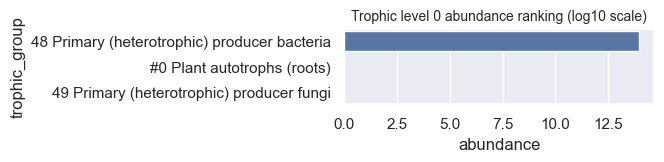

In [528]:
# trophic level 0
tl0_abund = {x: round(math.log10(y["Abundance"]), 2) for x,y in G.nodes(data=True) if y["trophic_level"]==0}
tl0_abund = sorted(tl0_abund.items(), key=itemgetter(1), reverse=True)

# plot trophic level 0 abundance
log_tl0_abund_df = pd.DataFrame(log_tl0_abund, columns= ["trophic_group", "abundance"])
fig, plot = plt.subplots(figsize = (4,1), dpi = 100)
sns.barplot(y="trophic_group", x="abundance", data=log_tl0_abund_df)
plot.set_title('Trophic level 0 abundance ranking (log10 scale)', fontsize = 10);

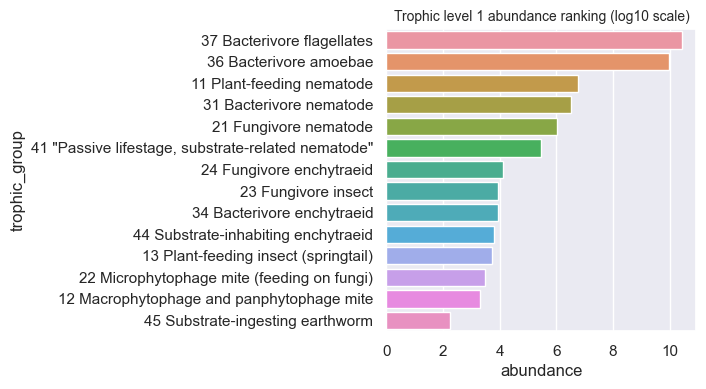

In [519]:
# Rank trophic groups by abundance per trophic level
# trophic level 1
tl1_abund = {x: round(math.log10(y["Abundance"]), 2) for x,y in G.nodes(data=True) if y["trophic_level"]==1}
log_tl1_abund = sorted(tl1_abund.items(), key=itemgetter(1), reverse=True) 

# plot trophic level 1 abundance
log_tl1_abund_df = pd.DataFrame(log_tl1_abund, columns= ["trophic_group", "abundance"])
fig, plot = plt.subplots(figsize = (4,4), dpi = 100)
sns.barplot(y="trophic_group", x="abundance", data=log_tl1_abund_df)
plot.set_title('Trophic level 1 abundance ranking (log10 scale)', fontsize = 10);

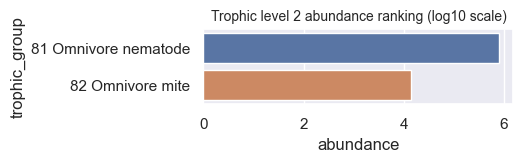

In [515]:
# trophic level 2
tl2_abund = {x: round(math.log10(y["Abundance"]), 2) for x,y in G.nodes(data=True) if y["trophic_level"]==2}
log_tl2_abund = sorted(tl2_abund.items(), key=itemgetter(1), reverse=True) 

# plot trophic level 2 abundance
log_tl2_abund_df = pd.DataFrame(log_tl2_abund, columns= ["trophic_group", "abundance"])
fig, plot = plt.subplots(figsize = (4,1), dpi = 100)
sns.barplot(y="trophic_group", x="abundance", data=log_tl2_abund_df)
plot.set_title('Trophic level 2 abundance ranking (log10 scale)', fontsize = 10);

Ranking of abundances at trophic level 3:


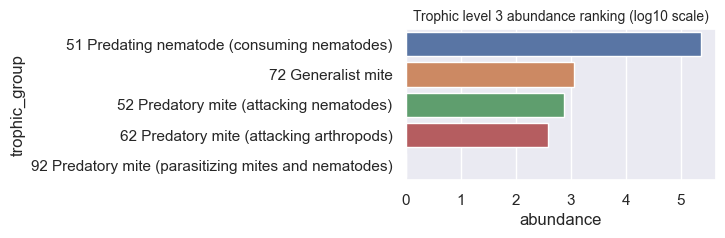

In [520]:
# trophic level 3
tl3_abund = {x: (y["Abundance"]) for x,y in G.nodes(data=True) if y["trophic_level"]==3 }
print(f"Ranking of abundances at trophic level 3:")
tl3_abund = sorted(tl3_abund.items(), key=itemgetter(1), reverse=True) 

# custom log function accepting 0 as value
def cust_log(tuple_list, base):
    l = []
    for x, y in tuple_list:
        if y != 0:
            l.append((x, math.log(y, base)))
        else:
            l.append((x, 0.0))  
    return l

log_tl3_abund = cust_log(tl3_abund, 10)

# plot trophic level 3 abundance
log_tl3_abund_df = pd.DataFrame(log_tl3_abund, columns= ["trophic_group", "abundance"])
fig, plot = plt.subplots(figsize = (4,2), dpi = 100)
sns.barplot(y="trophic_group", x="abundance", data=log_tl3_abund_df)
plot.set_title('Trophic level 3 abundance ranking (log10 scale)', fontsize = 10);

Ranking of abundances at trophic level 2 and 3:


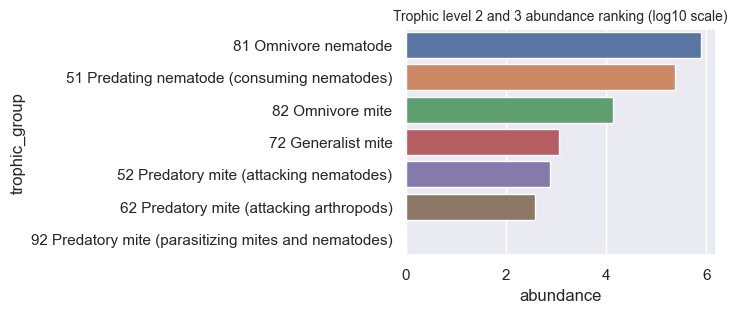

In [523]:
# trophic level 2 and 3
tl2and3_abund = {x: (y["Abundance"]) for x,y in G.nodes(data=True) if y["trophic_level"]== 2 or y["trophic_level"]==3}
print(f"Ranking of abundances at trophic level 2 and 3:")
tl2and3_abund = sorted(tl2and3_abund.items(), key=itemgetter(1), reverse=True)
log_tl2and3_abund = cust_log(tl2and3_abund, 10)

# plot trophic level 2 and 3 abundance
log_tl2and3_abund_df = pd.DataFrame(log_tl2and3_abund, columns= ["trophic_group", "abundance"])
fig, plot = plt.subplots(figsize = (4,3), dpi = 100)
sns.barplot(y="trophic_group", x="abundance", data=log_tl2and3_abund_df)
plot.set_title('Trophic level 2 and 3 abundance ranking (log10 scale)', fontsize = 10);